In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
import random

from torch.utils.data import DataLoader



In [ ]:
import time
class stopwatch():
    def __init__(self):
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def lap(self,return_time = False):
        if self.start_time == None:
            print('Stopwatch not started')
            return None
        seconds_passed = time.time() - self.start_time
        print(f'Time passed: {seconds_passed:.1f} seconds')
        if return_time:
            return seconds_passed


sw = stopwatch()


In [ ]:
torch.manual_seed(42)
LR = 1e-5 #learning rate
CHECKPOINT = 'Qwen/Qwen2-0.5B-Instruct'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
model = AutoModelForCausalLM.from_pretrained(CHECKPOINT,
                                             dtype = torch.bfloat16).to(device)
model.train()

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


In [ ]:
ref_model = AutoModelForCausalLM.from_pretrained(CHECKPOINT).to(device)
ref_model.eval()

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [ ]:
dataset = load_dataset('gsm8k','main')['train']
test_set = load_dataset('gsm8k','main')['test']


def format_prompt(question):
    messages = [{'role':'system','content':'Think step by step to answer the question given to you. After clearly stating your reasoning, state your final numerical answer after "#### ". For example if the answer is 2 finish your answer with: #### 2. The final answer is always an integer with no spaces'},
                {'role':'user','content':question}]

    formatted_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True,tokenize= False)
    return formatted_prompt

In [ ]:
def extract_answer(text):
    pattern = r'#### (\d+)'
    matches = re.findall(pattern, text)
    if matches:
        try:
            return int(matches[-1])
        except OverflowError:
            return None # Handle cases where the extracted number is too large
    else:
        return None

def map_func(example):
    prompt = format_prompt(example['question'])
    solution = example['answer']
    answer = extract_answer(solution)

    return {'prompt':prompt,'solution':solution,'answer':answer}

In [ ]:
dataset = dataset.map(map_func)
dataset = dataset.filter(lambda x:x['answer'] is not None)

test_dataset = test_set.map(map_func)
test_dataset = test_dataset.filter(lambda x:x['answer'] is not None)

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
loader = DataLoader(dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)


In [ ]:
len(loader),len(test_loader)

(234, 42)

In [ ]:
def generate_answers(prompt,num_return_sequences = 8,temp = 0.7,completion_dict = False):
    '''
    input:
    prompt:List[str]
    output:
    answers:List[str]
    '''
    prompt_inputs = tokenizer(prompt, return_tensors="pt",padding = True,padding_side='left').to(device)
    prompt_length = len(prompt_inputs['input_ids'][0])

    outputs = model.generate(
        **prompt_inputs,
        num_return_sequences=num_return_sequences,
        max_new_tokens=1024,
        do_sample=True,
        temperature=temp,
        top_p=0.95,
    )
    if completion_dict:
        completions = tokenizer.batch_decode(outputs[:,prompt_length:], skip_special_tokens=True)
        compeltion_dict = {}
        for prompt_num,i in enumerate(range(0,len(outputs),num_return_sequences)):
            compeltion_dict[prompt[prompt_num]] = tokenizer.batch_decode(outputs[i:i+num_return_sequences,prompt_length:], skip_special_tokens=True)

        return compeltion_dict



    return tokenizer.batch_decode(outputs[:,prompt_length:], skip_special_tokens=True)

def calculate_rewards(rollouts,real_answer,length_penalty_factor = 0):
    '''
    input:
    rollouts:List[str], real_answer:int
    output:
    rewards:List[int]
    '''

    rewards = []
    for rollout in rollouts:
        ans  = extract_answer(rollout)
        if ans == None:
            rewards.append(0)
            continue
        if ans == real_answer:
            rewards.append(max(1 - length_penalty_factor*max(len(tokenizer.encode(rollout)) - 35,0),0))
        else:
            rewards.append(0)

    max_reward = max(rewards)
    if max_reward == 0:
        max_reward = 1
    rewards = [reward/max_reward for reward in rewards]
    return rewards

def calculate_advantages(rewards):
    '''inputs:
    rewards:List[int]
    output:
    advantages:List[int]
    '''
    advantages = []
    mean = sum(rewards)/len(rewards)
    for reward in rewards:
        advantages.append(reward-mean)
    return advantages


def calculate_accuracy(rollouts,real_answer):
    '''
    input:
    rollouts:List[str], real_answer:int
    output:
    accuracy:float
    '''
    rewards = calculate_rewards(rollouts,real_answer)
    return sum(rewards)/len(rewards)

In [ ]:
def get_logprobs(model,prompt,completion,sum = False,mean = False,use_cache = False):
    prompt_ids = tokenizer.encode(prompt,return_tensors = 'pt')
    completion_ids = tokenizer.encode(completion,return_tensors = 'pt')
    full_prompt = torch.cat([prompt_ids, completion_ids],dim = 1)
    prompt_length = len(prompt_ids[0])

    full_prompt = full_prompt.to(device)
    if use_cache:
        logits = model(full_prompt,use_cache = True).logits
    else:
        logits = model(full_prompt).logits

    cross_entropy = torch.nn.CrossEntropyLoss(reduction = 'none')
    completion_logits = logits[0,prompt_length-1:-1]
    targets= completion_ids.squeeze(0).to(device)

    neg_log_probs = cross_entropy(completion_logits,targets)
    if sum:
        return -neg_log_probs.sum()
    if mean:
        return -neg_log_probs.mean()

    return -neg_log_probs






In [ ]:

def calculate_loss(prompt,completions,real_answer,ref_model = ref_model,beta= 0.0,epsilon = 0.2,return_kl_div = False,length_penalty_factor = 0):
    '''
    input:
    prompt:str, completions:List[str], real_answer:int
    output:
    loss:float
    '''
    rewards = calculate_rewards(completions,real_answer,length_penalty_factor = length_penalty_factor)
    advantages = calculate_advantages(rewards)
    total_length = 0
    total_objective = 0
    for completion,advantage in zip(completions,advantages):

        tokenized_completition_length = len(tokenizer.encode(completion))
        total_length += tokenized_completition_length
        sum_logprobs = get_logprobs(model,prompt,completion,sum = True)
        rA =sum_logprobs*advantage

        kl_component = 0

        if beta>0.0 or return_kl_div:
            kl_divs = []
            with torch.no_grad():
                sum_logprobs_ref = get_logprobs(ref_model,prompt,completion,sum = True,use_cache=True)


            kl_div = (sum_logprobs - sum_logprobs_ref)/tokenized_completition_length
            kl_divs.append((kl_div.item()/tokenized_completition_length))
            total_objective += rA + beta*kl_div
        else:
            total_objective += rA
    if return_kl_div:
        return -total_objective/(1024*len(completions)),sum(kl_divs)/len(kl_divs)
    else:
        return -total_objective/(1024*len(completions))

def calculate_loss_for_solution(prompt,solution):
    '''
    input:
    prompt:str, solution:str
    output:
    loss:float
    '''
    tokenized_solution_length = len(tokenizer.encode(solution))
    objective = get_logprobs(model,prompt,solution,sum = True)/tokenized_solution_length
    return -objective

In [ ]:
sw.start()

EPOCHS = 1
epoch_accuracies = []
for epoch in range(EPOCHS):
    batch_kl_divs = []
    batch_accuracies = []
    batch_average_lengths = []
    for batch_num,batch in enumerate(loader):
        if batch_num < 200:
            length_penalty_factor = 0.01
        elif batch_num < 225:
            length_penalty_factor = -0.01
        else:
            length_penalty_factor = 0
        prompts = batch['prompt']
        real_answers = batch['answer']
        solutions = batch['solution']

        with torch.no_grad():
            completion_dict = generate_answers(prompts,completion_dict=True)


        optimizer.zero_grad()

        average_length = []
        seconds_passed = []
        accuracies = []
        kl_divs = []
        for prompt,real_answer,solution in zip(prompts,real_answers,solutions):
            completions = completion_dict[prompt]
            accuracy = calculate_accuracy(completions,real_answer)
            accuracies.append(accuracy)
            average_length.append(sum([len(tokenizer.encode(completion)) for completion in completions])/len(completions))

            loss,kl_div = calculate_loss(prompt,completions,real_answer,return_kl_div=True,length_penalty_factor = length_penalty_factor,beta = 0.1)
            kl_divs.append(kl_div)
            # loss += calculate_loss_for_solution(prompt,solution)
            loss /= len(prompts)
            loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        batch_accuracies.append(sum(accuracies)/len(accuracies))
        batch_average_lengths.append(sum(average_length)/len(average_length))
        batch_kl_divs.append(sum(kl_divs)/len(kl_divs))
        status_for_print = f'''
        Epoch:{epoch}
        Batch Num:{batch_num}
        Accuracy:{sum(accuracies)/len(accuracies)}
        Moving Average Accuracy:{sum(batch_accuracies[-10:])/len(batch_accuracies[-10:])}
        Average Length:{sum(average_length)/len(average_length)}
        Moving Average Length:{sum(batch_average_lengths[-10:])/len(batch_average_lengths[-10:])}
        Average KL Divergence:{sum(kl_divs)/len(kl_divs)}
        Moving Average KL Divergence:{sum(batch_kl_divs[-10:])/len(batch_kl_divs[-10:])}
        '''
        print(status_for_print)
        seconds_passed.append(sw.lap(return_time=True))

    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))








        Epoch:0
        Batch Num:0
        Accuracy:0.1015625
        Moving Average Accuracy:0.1015625
        Average Length:190.66796875
        Moving Average Length:190.66796875
        Average KL Divergence:-5.734943743798925e-06
        Moving Average KL Divergence:-5.734943743798925e-06
        
Time passed: 88.0 seconds

        Epoch:0
        Batch Num:1
        Accuracy:0.24609375
        Moving Average Accuracy:0.173828125
        Average Length:114.0390625
        Moving Average Length:152.353515625
        Average KL Divergence:0.001127595477258657
        Moving Average KL Divergence:0.000560930266757429
        
Time passed: 147.2 seconds

        Epoch:0
        Batch Num:2
        Accuracy:0.3671875
        Moving Average Accuracy:0.23828125
        Average Length:80.40625
        Moving Average Length:128.37109375
        Average KL Divergence:0.003154935347912764
        Moving Average KL Divergence:0.0014255986271425405
        
Time passed: 195.0 seconds

     

In [ ]:
completions

[' James bought 10 shirts, and the number of pants was half the number of shirts, so he bought 10/2 = 5 pants.\nThe cost of each shirt is $6, so the total cost for the shirts is 10 * $6 = $60.\nThe cost of each pant is $8, so the total cost for the pants is 5 * $8 = $40.\nTherefore, the total cost for all the items is $60 + $40 = $100.\n\n#### 100####',
 ' James bought 10 shirts.\nHe bought half as many pants as shirts, so he bought 10/2 = 5 pants.\nEach shirt costs $6, so the total cost of shirts is 10 * $6 = $60.\nEach pant costs $8, so the total cost of pants is 5 * $8 = $40.\nThe total cost of everything is $60 + $40 = $100.\n\n#### 100####',
 ' He bought 10 shirts, and half as many pants, so he bought 10/2 = 5 pants.\nEach shirt costs $6, so the total cost of shirts is 10 * $6 = $60.\nEach pant costs $8, so the total cost of pants is 5 * $8 = $40.\nThe total cost of everything is $60 + $40 = $100.\n\n#### 100####',
 ' James bought 10 shirts, and the pants are half as many, so he b

In [ ]:
model.push_to_hub('AndkyrUCL/compressed_GRPO_trained_model',use_auth_token = True)

/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:916: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmprz358ey5/model.safetensors    :   0%|          |  613kB /  988MB            

CommitInfo(commit_url='https://huggingface.co/AndkyrUCL/compressed_GRPO_trained_model/commit/143e71a09c8d9d19c044752cf7b8dd2cc848e397', commit_message='Upload Qwen2ForCausalLM', commit_description='', oid='143e71a09c8d9d19c044752cf7b8dd2cc848e397', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AndkyrUCL/compressed_GRPO_trained_model', endpoint='https://huggingface.co', repo_type='model', repo_id='AndkyrUCL/compressed_GRPO_trained_model'), pr_revision=None, pr_num=None)

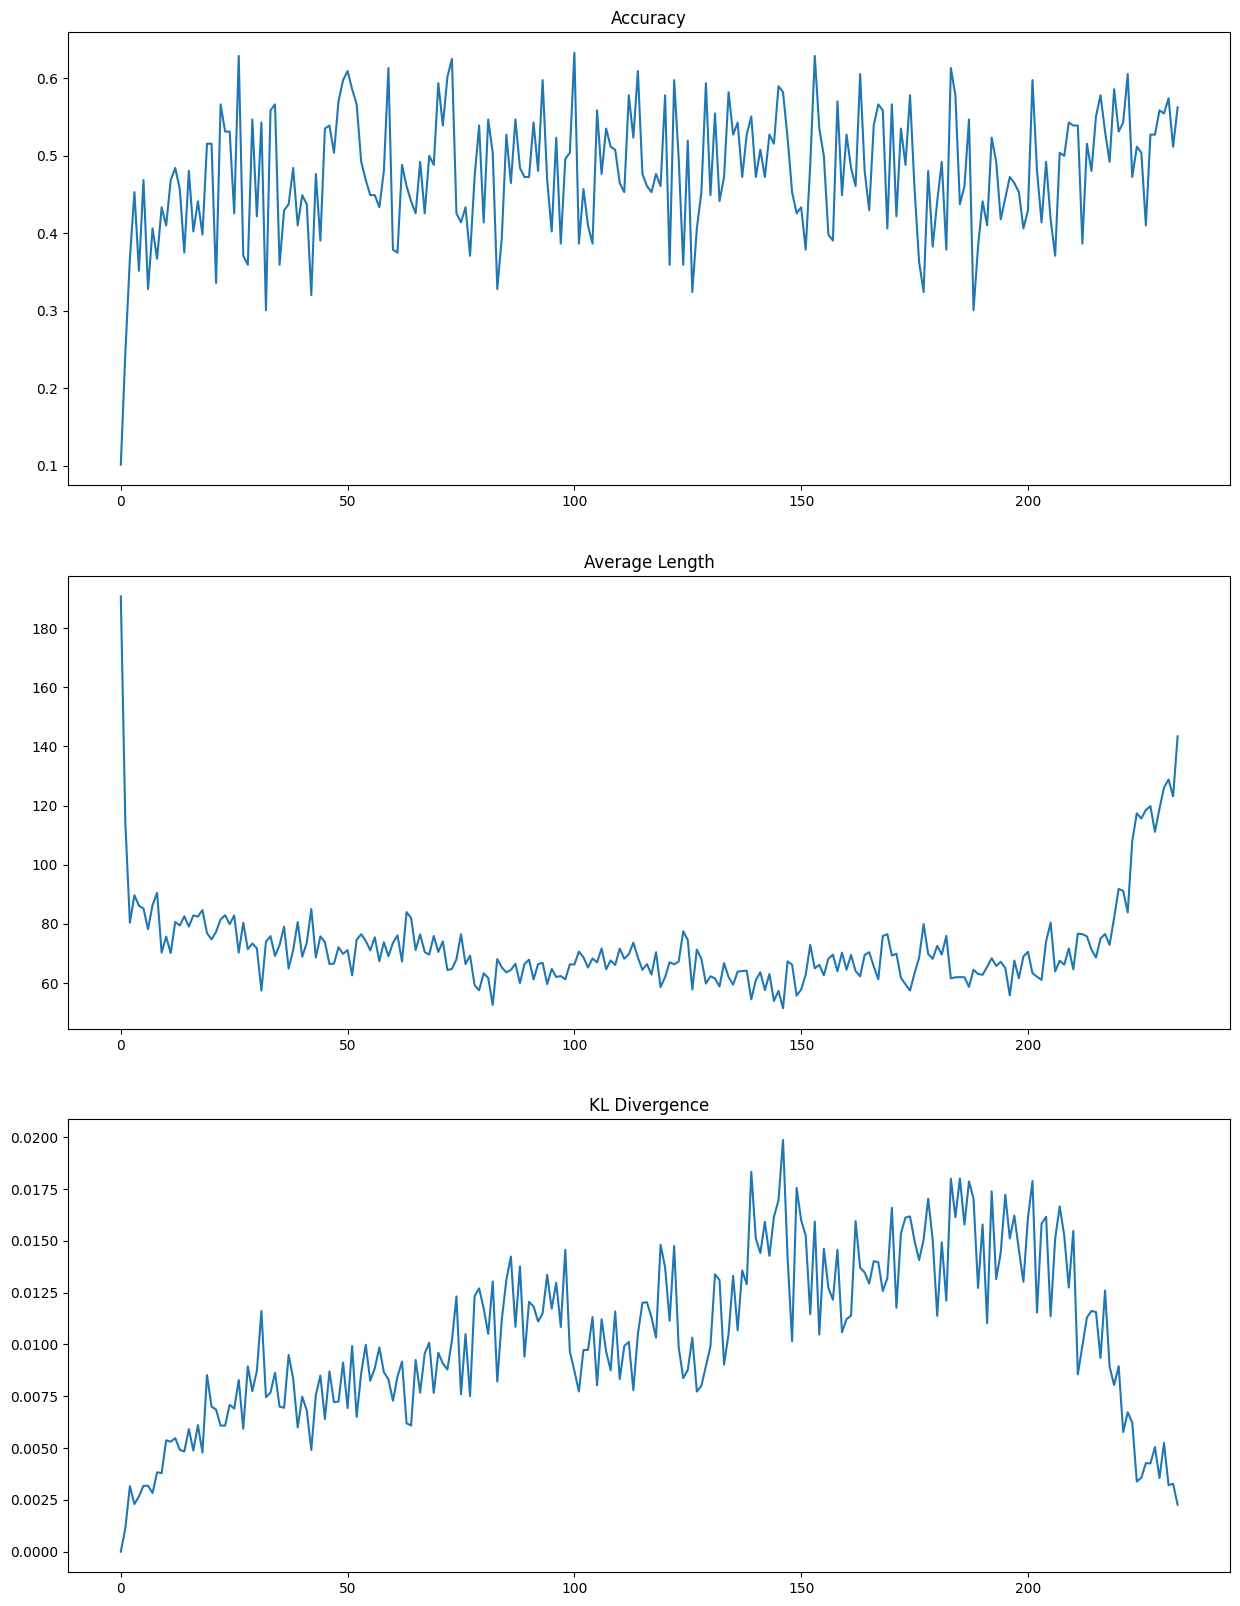

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(3,1,figsize=(15,20))
plt.subplot(3,1,1)
plt.plot(batch_accuracies)
plt.title('Accuracy')
plt.subplot(3,1,2)
plt.plot(batch_average_lengths)
plt.title('Average Length')
plt.subplot(3,1,3)
plt.plot(batch_kl_divs)
plt.title('KL Divergence')
plt.show()